In [26]:
# set plots inline for ipython
%matplotlib inline

# import system & ipython utils
import os
import subprocess
from IPython.display import Image

# numpy and visualization libs
import pandas as pd
import numpy as np
import seaborn as sns

# import data preprocessing, cross validaiton & classifier libs
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

# performance measures
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss, hamming_loss
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import matthews_corrcoef, f1_score, precision_score, recall_score
from sklearn.metrics import accuracy_score

# set random seed
rand_state = np.random.RandomState(32)

# maps all n x f samples from each participants to a summarized feature vector 
# of size 1 x (f * summary_dimensions) where summary_dimensions are central tendancy and dispertion metrics
summarize_subjects = False
apply_standard_scaler = True

In [27]:
#set paths to datasets
train_data = 'train_data.txt'
test_data = 'test_data.txt' # entirely disjoint set of subjects

# move to data path relative to the .ipnyb base dir
if os.getcwd().split('/')[-1] != 'pd_msr_data':
    os.chdir('./pd_msr_data')

# set dataset column labels
columns = ['subj_id', 'jitter_local', 'jitter_absolute', 'jitter_rap', 'jitter_ppq5', 'jitter_ddp',
        'shimmer_local', 'shimmer_dB', 'shimmer_apq3', 'shimmer_apq5', 'shimmer_apq11', 'shimmer_dda',
        'AC', 'NTH', 'HTN', 'median_pitch', 'mean_pitch', 'standard_dev', 'min_pitch', 'max_pitch',
        'num_pulses', 'num_periods', 'mean_period', 'standard_dev_period', 'fraction_locally_unvoiced_frames',
        'num_voice_breaks', 'deg_voice_breaks','UPDRS','pd']
    
df = pd.read_csv(train_data)
df.columns = columns

# compute mean and standard deviation of features across subjects
if (summarize_subjects):
    # group subjects and summarize data using central tendancy and dispertion metrics
    target_labels = df.drop_duplicates(['subj_id'])[['subj_id','UPDRS','pd']].set_index('subj_id')
    df_mean = df.drop(['UPDRS','pd'], axis=1).groupby('subj_id').mean()
    df_std = df.drop(['UPDRS','pd'], axis=1).groupby('subj_id').std()
    
    # rename() filters the column labels and concats w/ y if it is a feature
    rename = lambda x,y: x if x in ['UPDRS','pd'] else x + y
    
    # rename column labels to reflect summary operation
    df_mean.columns = [rename(col_name,'_m') for col_name, col in df_mean.transpose().iterrows()]
    df_std.columns = [rename(col_name,'_s') for col_name, col in df_std.transpose().iterrows()]
    
    # drop target label columns to avoid redundancy
    #df_mean = df_mean.drop(['UPDRS','pd'], axis=1)
    
    # merge means and std dataframes back into df
    df = pd.concat([df_mean, df_std, target_labels], axis=1)
else:
    df = df.set_index('subj_id')

# split X, y (PD binary label) and updrs (clinical rating regression target) from the dataframe
X = df.drop(['UPDRS','pd'], axis=1)
y = df['pd']
updrs = df['UPDRS']

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

if apply_standard_scaler:
    # fit a standardScaler to normalize all input to zero mean and unit variance
    scaler = StandardScaler().fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), columns = X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

# init containers for collecting stats comparing the top algorithm from each class (knn,dtree,ANN...)
algorithm_list = ['k-Nearest Neighbors', 'Decision Tree', 'Boosted Tree', 'Support Vector Machine', 'Neural Network']
algorithm_performance = pd.DataFrame(index=algorithm_list,columns=['f1','precision','recall','accuracy'])

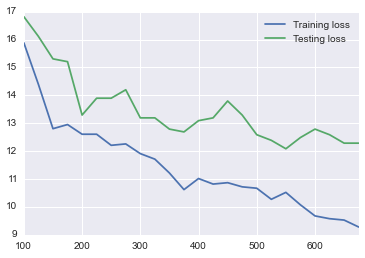

In [28]:
# run KNN for different training set sizes, compare [ loss(train), loss(test) ]
n_training = range(100,y_train.shape[0],25)
knn_performance = pd.DataFrame(index=n_training, columns=['Training loss', 'Testing loss'])
                               
for n in n_training:
    knn = KNeighborsClassifier(n_neighbors=10)
    knn.fit(X_train[:n], y_train[:n])
    
    train_pred = knn.predict(X_train)
    test_pred = knn.predict(X_test)
    
    knn_performance.loc[n] = {'Training loss' : log_loss(y_train, train_pred),
                              'Testing loss' : log_loss(y_test, test_pred)}
    

# plot train v test mmc
knn_performance.plot()

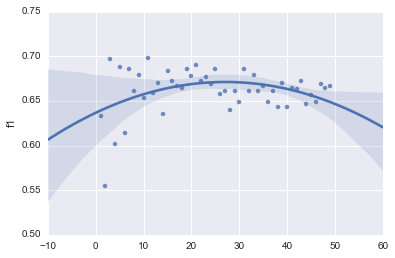

In [29]:
# run KNN for different values of k
k_range = range(1,50)
knn_performance = pd.DataFrame(index=k_range, columns=['f1','precision','recall','accuracy'])
                               
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    
    knn_performance.loc[k] = {'f1' : f1_score(y_test, y_pred),
                              'precision' : precision_score(y_test, y_pred),
                              'recall' : recall_score(y_test, y_pred),
                              'accuracy' : accuracy_score(y_test, y_pred)}

# add the best scores for the algorithm to the performance dataframe
algorithm_performance.loc['k-Nearest Neighbors'] = {col_name : np.max(col) 
                                                    for col_name, col in 
                                                    knn_performance.transpose().iterrows()}

# plot mcc(k)
knn_plot = sns.regplot(x=knn_performance.index.get_values(), y='f1', data=knn_performance, order=2)


In [30]:
# determine optimal pruning for the decision trees using cross-validation grid-search on max_depth
depth_range = range(1,20)
tree_param_grid = [{'max_depth' : depth_range}]

tree_gs = GridSearchCV(DecisionTreeClassifier(random_state=rand_state),
                       tree_param_grid, cv=5, scoring='f1')

tree_gs.fit(X_train, y_train)

# plot f1 over max_depth
for params, mean_score, scores in tree_gs.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() / 2, params))

# save the best tree for further analysis
best_tree = tree_gs.best_estimator_

0.626 (+/-0.021) for {'max_depth': 1}
0.528 (+/-0.046) for {'max_depth': 2}
0.675 (+/-0.016) for {'max_depth': 3}
0.673 (+/-0.015) for {'max_depth': 4}
0.655 (+/-0.022) for {'max_depth': 5}
0.644 (+/-0.007) for {'max_depth': 6}
0.629 (+/-0.018) for {'max_depth': 7}
0.617 (+/-0.008) for {'max_depth': 8}
0.605 (+/-0.012) for {'max_depth': 9}
0.614 (+/-0.013) for {'max_depth': 10}
0.604 (+/-0.016) for {'max_depth': 11}
0.629 (+/-0.017) for {'max_depth': 12}
0.610 (+/-0.011) for {'max_depth': 13}
0.603 (+/-0.016) for {'max_depth': 14}
0.613 (+/-0.011) for {'max_depth': 15}
0.617 (+/-0.008) for {'max_depth': 16}
0.622 (+/-0.008) for {'max_depth': 17}
0.622 (+/-0.008) for {'max_depth': 18}
0.622 (+/-0.008) for {'max_depth': 19}


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=<mtrand.RandomState object at 0x10e77aad0>,
            splitter='best')

             precision    recall  f1-score   support

          0       0.53      0.78      0.63       162
          1       0.66      0.38      0.48       181

avg / total       0.60      0.57      0.55       343



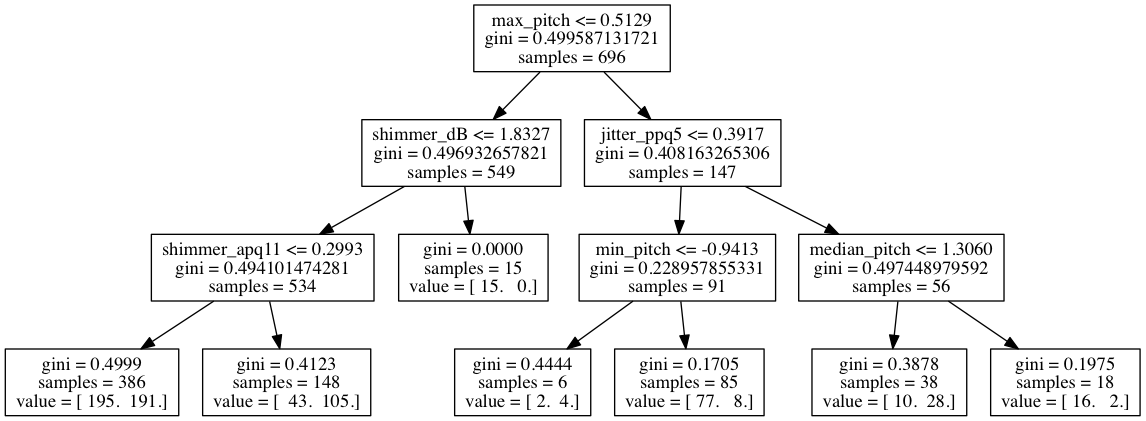

In [31]:
# visualizes the optimal tree
print best_tree
print
print classification_report(y_test, best_tree.predict(X_test))

with open('tree.dot', 'w') as dotfile:
    export_graphviz(
        best_tree,
        dotfile,
        feature_names=X_train.columns)
    
subprocess.call(['dot','-Tpng','tree.dot','-o','tree.png'])
Image(filename='tree.png')

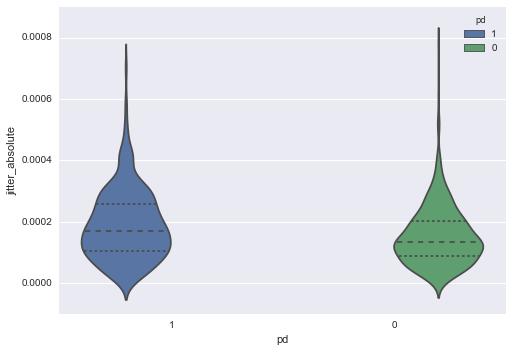

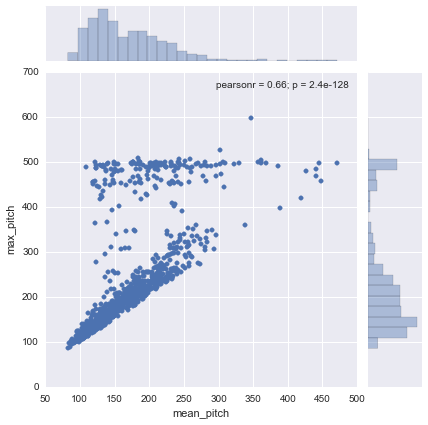

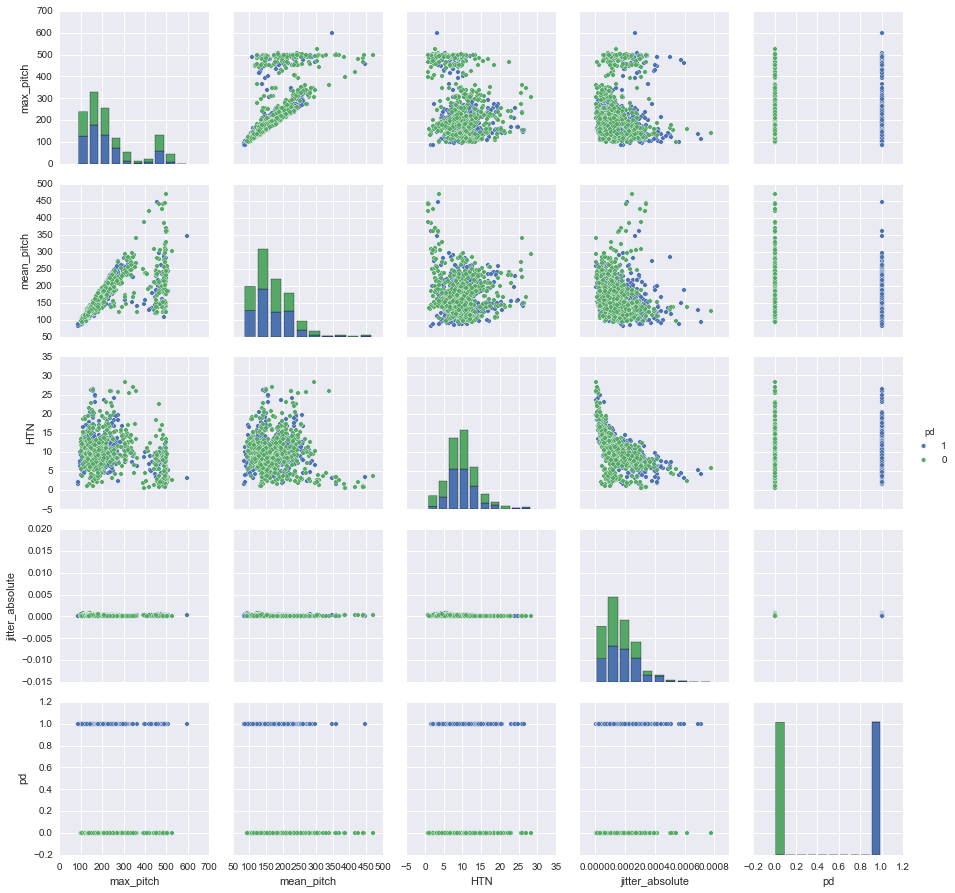

In [8]:
# exploritory / descriptive visualizaitons
sns.violinplot(x='pd',y='jitter_absolute',data=df, hue='pd',inner="quart")
sns.jointplot('mean_pitch','max_pitch',data=df,kind='scatter')
sns.pairplot(df[['max_pitch','mean_pitch','HTN','jitter_absolute','pd']], hue='pd')